In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [65]:
# Load data
df = pd.read_csv("diabetes.csv")

In [66]:
# Tangani nilai 0 sebagai NaN
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_features] = df[zero_features].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

In [67]:
# Feature engineering
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Age_Insulin_Ratio'] = df['Age'] / (df['Insulin'] + 1e-6)

X = df.drop("Outcome", axis=1)
y = df["Outcome"]

In [68]:
# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [69]:
# Imbalance handling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

In [70]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.15, stratify=y_res, random_state=42
)

In [71]:
# Model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [72]:
# Callbacks
early_stop = EarlyStopping(monitor='val_auc', patience=12, verbose=1, restore_best_weights=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)


In [73]:
# Train model
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs=150, batch_size=64,
                    callbacks=[early_stop, reduce_lr], verbose=1)


Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.5189 - auc: 0.5282 - loss: 1.0622 - val_accuracy: 0.6765 - val_auc: 0.7831 - val_loss: 0.7424 - learning_rate: 5.0000e-04
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7021 - auc: 0.7707 - loss: 0.7514 - val_accuracy: 0.7412 - val_auc: 0.8147 - val_loss: 0.7051 - learning_rate: 5.0000e-04
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7423 - auc: 0.8379 - loss: 0.6388 - val_accuracy: 0.7000 - val_auc: 0.8277 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7529 - auc: 0.8581 - loss: 0.6068 - val_accuracy: 0.7176 - val_auc: 0.8355 - val_loss: 0.6908 - learning_rate: 5.0000e-04
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7860 - auc: 0.8729 - loss: 0.5731 - val_accuracy: 0.7059 - val_auc: 0.8433 - val_loss: 0.6917 - learning_rate: 5.0000e-04
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accurac

In [74]:
# Evaluate
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n" + "="*40)
print(" Evaluasi Final Model ".center(40, '='))
print("="*40)

print(f"\nAkurasi: {accuracy_score(y_test, y_pred):.2f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_prob):.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Negatif", "Positif"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

========= Evaluasi Final Model =========

Akurasi: 0.83
AUC-ROC: 0.88

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.83      0.84      0.83        75
     Positif       0.84      0.83      0.83        75

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150


Confusion Matrix:
[[63 12]
 [13 62]]


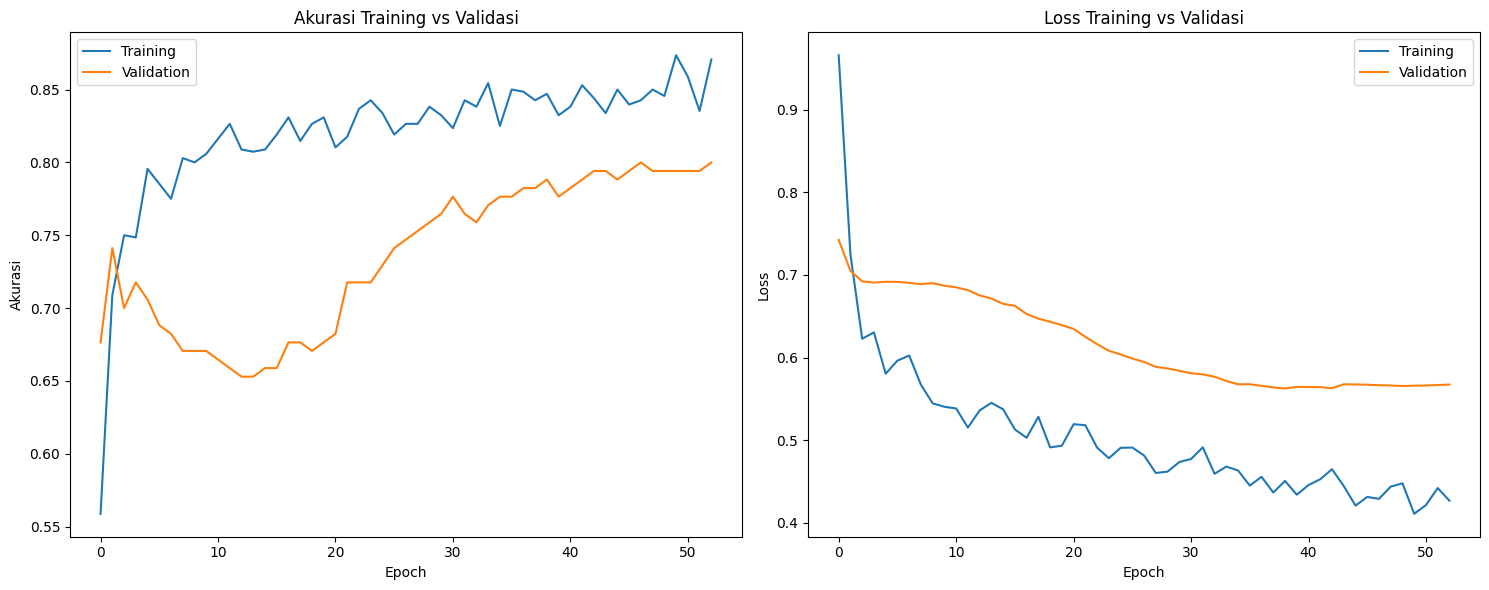

In [75]:
# Plot akurasi dan loss
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Training vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Training vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()